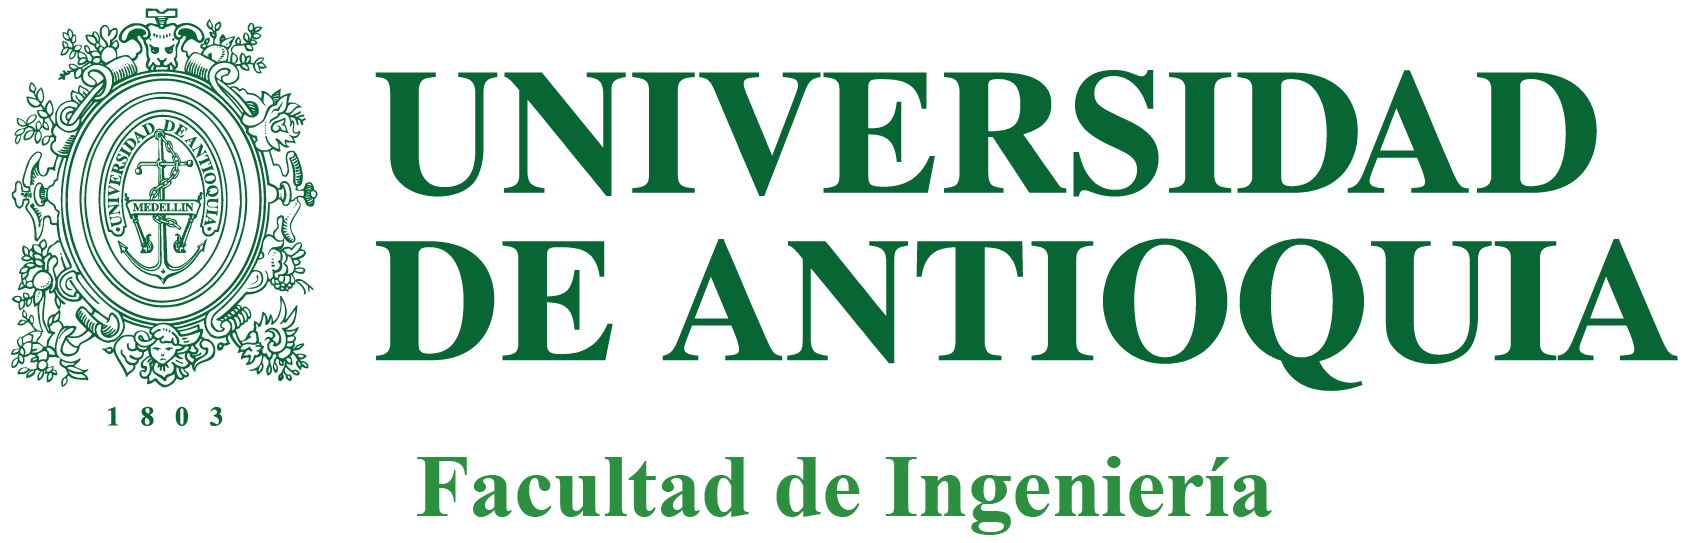
---

**Especialización en Analítica y Ciencia de Datos**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
  <a href="https://www.kaggle.com/code/melissaortegaalzate/04-transfer-learning-ipynb">
    <img src="https://img.shields.io/badge/Kaggle-20BEFF?logo=kaggle&logoColor=fff&style=flat" alt="View on Kaggle" style="height: 25px;">
  </a>
</div>


# Libraries & Settings

In [17]:
# System
import zipfile
import os
from pathlib import Path
import itertools
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data manipulation and processing
import numpy as np
import pandas as pd

# Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Callbacks and optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
#from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# GPU Consiguration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU.')
    
# Confirmation
print ('\nThe modules were sucesfully loaded.')

Using GPU.

The modules were sucesfully loaded.


In [ ]:
# Google Drive conection
!pip install gdown
import gdown

## Tensor flow configuration

In [ ]:
# System configuration
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x

tf.__version__

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [19]:
results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:
# Reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Functions

**Function to plot history of training**

In [20]:
# Function to plot history of training
def plot_history(history, title='Model training history'):
    """
    Function to plot the training history of a model.
    
    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.
    
    """
    # Convert the history to a DataFrame
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    max_epoch = hist['epoch'].max()
    
    # Determine if recall columns exist
    recall_columns = [col for col in hist.columns if 'recall' in col]
    num_plots = 2 if len(recall_columns) < 2 else 3
    
    # Found best epochs
    val_lowest_index = hist['val_loss'].idxmin()
    val_lowest = hist['val_loss'].min()
    index_loss = hist['epoch'][val_lowest_index]
    
    val_max_index = hist['val_accuracy'].idxmax()
    val_max = hist['val_accuracy'].max()
    index_acc = hist['epoch'][val_max_index]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Create figure and axes
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))
    fig.suptitle(title, fontsize=13,  fontweight='bold')

    # Ensure axes is always a list, even with a single subplot
    if num_plots == 1:
        axes = [axes]

    # Plot loss
    axes[0].plot(hist['epoch'], hist['loss'], 'o-r', label='Training')
    axes[0].plot(hist['epoch'], hist['val_loss'], '--', label='Validation')
    axes[0].set_xlim([0, max_epoch + 2])
    axes[0].set_ylim([0, max(hist['loss'].max(), hist['val_loss'].max()) * 1.1])
    axes[0].scatter(index_loss, val_lowest,s=60, c='green', label=loss_label)
    axes[0].set(ylabel='Loss', xlabel="Epochs")
    axes[0].set_title("Loss", fontweight='bold')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy
    axes[1].plot(hist['epoch'], hist['accuracy'], 'o-r', label='Training')
    axes[1].plot(hist['epoch'], hist['val_accuracy'], '--', label='Validation')
    axes[1].set_xlim([0, max_epoch + 2])
    axes[1].scatter(index_acc, val_max, s=60, c='green', label=acc_label)
    axes[1].set_ylim([hist['accuracy'].min() - 0.1, 1])
    axes[1].set(ylabel='Accuracy', xlabel="Epochs")
    axes[1].set_title('Accuracy', fontweight='bold')
    axes[1].legend()

    # Plot Recall (optional)
    if num_plots == 3:
        axes[2].plot(hist['epoch'], hist[recall_columns[0]], 'o-r', label='Training')
        axes[2].plot(hist['epoch'], hist[recall_columns[1]], '--', label='Validation')
        axes[2].set_xlim([0, max_epoch + 2])
        axes[2].set_ylim(([hist['accuracy'].min() - 0.1, 1]))
        axes[2].set_xlabel("Epochs")
        axes[2].set_ylabel("Recall")
        axes[2].set_title("Recall", fontweight='bold')
        axes[2].set_xticks(range(max_epoch + 1))
        axes[2].legend()

    # Adjust space between subplots and general title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show()

**Function to create confusion matrix**

In [21]:
# Function to create confusion matrix
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion matrix', cmap= plt.cm.YlGnBu):

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized confusion matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Load the dataset

In [22]:
# Download the preprocessed zip file from Google Drive

!gdown '1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0
From (redirected): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0&confirm=t&uuid=001c7282-0bcf-47cb-b5b9-229bfe44d31a
To: /tmp/data1.zip
100%|████████████████████████████████████████| 172M/172M [00:18<00:00, 9.06MB/s]


In [23]:
# Extract the files
local_zip = '/tmp/data1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [24]:
# Define # Directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Training directories
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

# Validation directories
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

# Test directories
test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Lists of files in folders
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

# Preprocessing: data augmentation and normalization

In [25]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None)
BATCH_SIZE = 32      # Number of samples per gradient update
STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
VALIDATION_STEPS = 10

In [26]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, rescale=1./255,)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, rescale=1./255,)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        color_mode='rgb')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb')

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [27]:
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.619.jpg', 'healthy.46.jpg', 'healthy.362.jpg', 'healthy.566.jpg', 'healthy.539.jpg', 'healthy.1274.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


# Instantiate the VGG16 model

Using the VGG16 weights, pre-trained on ImageNet. The the new input size upon import and set all layers to not trainable is defined:

In [28]:
# Create the base model from the pre-trained model VGG16 without top layers

base_model = VGG16(weights='imagenet',         # Load weights pre-treined on ImageNet
                   include_top=False,          # Do nor include the ImageNet classifier at the top
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [29]:
# Freeze the convolutional base layers
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Trainable params: Los pesos que se actualizarán durante el entrenamiento (mediante descenso del gradiente) para minimizar la pérdida.
Non-trainable params: son aquellos pesos que no serán entrenados, normalmente, el modelo los actualiza durante el paso hacia adelante.

# Create a new model: add new layers to the base model

Using Keras’ functional API to define the vgg16 output as input into a new set of fully-connected layers like so:

In [30]:
# Print and example of batch images
image_batch, label_batch = next(train_generator)
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 512])

This pre-trained model is used as a feature extractor, it converts each 224x224x3 image into a 7x7x512 block of features. That output will be then used to train some top layers on the dataset to get the predictions.

In [31]:
# Adding top custom Layers
x = base_model.output

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = GlobalAveragePooling2D()(x)

# Adding a dense and dropout layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Adding a dense classifier with softmax activation
ouputs = Dense(2, activation='softmax')(x)

Define a new model in terms of inputs and output, and proceed from there on as before:

In [32]:
# Visualize the new model
transfer_model = Model(inputs = base_model.input,
                      outputs = ouputs)

transfer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Create the model

In [33]:
# Compile the model using the best baseline parameters
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.Recall()])

### Callbacks

In [34]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [35]:
time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)

### Compute baseline metrics

In [36]:
initial_loss, initial_accuracy = transfer_model.evaluate(validation_generator)

2024-05-25 13:29:26.458073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-25 13:29:26.458138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-25 13:29:26.458181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-25 13:29:26.458204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-25 13:29:26.458216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-25 13:29:26.458227: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-25 13:29:26.458239: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-25 13:29:26.458251: E external/local_xla/xla/se

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4297 - loss: 0.7642 - recall: 0.4297 

I0000 00:00:1716643781.539600     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4024 - loss: 0.7717 - recall: 0.4024

2024-05-25 13:29:42.884988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.5554, expected 3.07265
2024-05-25 13:29:42.885040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13778, expected 2.65504
2024-05-25 13:29:42.885049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.34289, expected 2.86015
2024-05-25 13:29:42.885058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 3.72137, expected 3.23862
2024-05-25 13:29:42.885066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.32536, expected 2.84261
2024-05-25 13:29:42.885073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199: 3.81774, expected 3.335
2024-05-25 13:29:42.885083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.84685, expected 2.36411
2024-05-25 13:29:42.885111: E external/local_xla

8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3947 - loss: 0.7749 - recall: 0.3947


ValueError: too many values to unpack (expected 2)

# Train VGG16 transfer model

In [37]:
# Train the transfer model
history = transfer_model.fit(train_generator,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            validation_data = validation_generator,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            callbacks = [time_callback, early_stopping]
                            )

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.5938 - loss: 0.6979 - recall: 0.5938 - val_accuracy: 0.7470 - val_loss: 0.5063 - val_recall: 0.7470
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.7890 - loss: 0.4811 - recall: 0.7890 - val_accuracy: 0.8696 - val_loss: 0.4120 - val_recall: 0.8696
Epoch 3/50
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8393 - loss: 0.4144 - recall: 0.8393

2024-05-25 13:38:54.798888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150528: 4.38462, expected 3.57489
2024-05-25 13:38:54.799059: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150529: 4.90744, expected 4.09771
2024-05-25 13:38:54.799082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150530: 5.28052, expected 4.47079
2024-05-25 13:38:54.799095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150531: 5.54085, expected 4.73112
2024-05-25 13:38:54.799106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150532: 4.33636, expected 3.52662
2024-05-25 13:38:54.799117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150533: 5.02811, expected 4.21837
2024-05-25 13:38:54.799128: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150534: 5.7047, expected 4.89496
2024-05-25 13:38:54.7

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 964ms/step - accuracy: 0.8394 - loss: 0.4110 - recall: 0.8394 - val_accuracy: 0.8458 - val_loss: 0.3549 - val_recall: 0.8458
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.8376 - loss: 0.3935 - recall: 0.8376 - val_accuracy: 0.8617 - val_loss: 0.3352 - val_recall: 0.8617
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.8556 - loss: 0.3485 - recall: 0.8556 - val_accuracy: 0.8735 - val_loss: 0.3139 - val_recall: 0.8735
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - accuracy: 0.8668 - loss: 0.3562 - recall: 0.8668 - val_accuracy: 0.8656 - val_loss: 0.3037 - val_recall: 0.8656
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8796 - loss: 0.3321 - recall: 0.8796 - val_accuracy: 0.8617 - val_loss: 0.3097 - val_recall: 0.8617
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.8571 - loss: 0.3714 - recall: 0.8571 - val_accuracy: 0.8893 - val_loss: 0.3039 - val_recall: 0.8893
Epoch 9/50
20/

### Plot learning curves

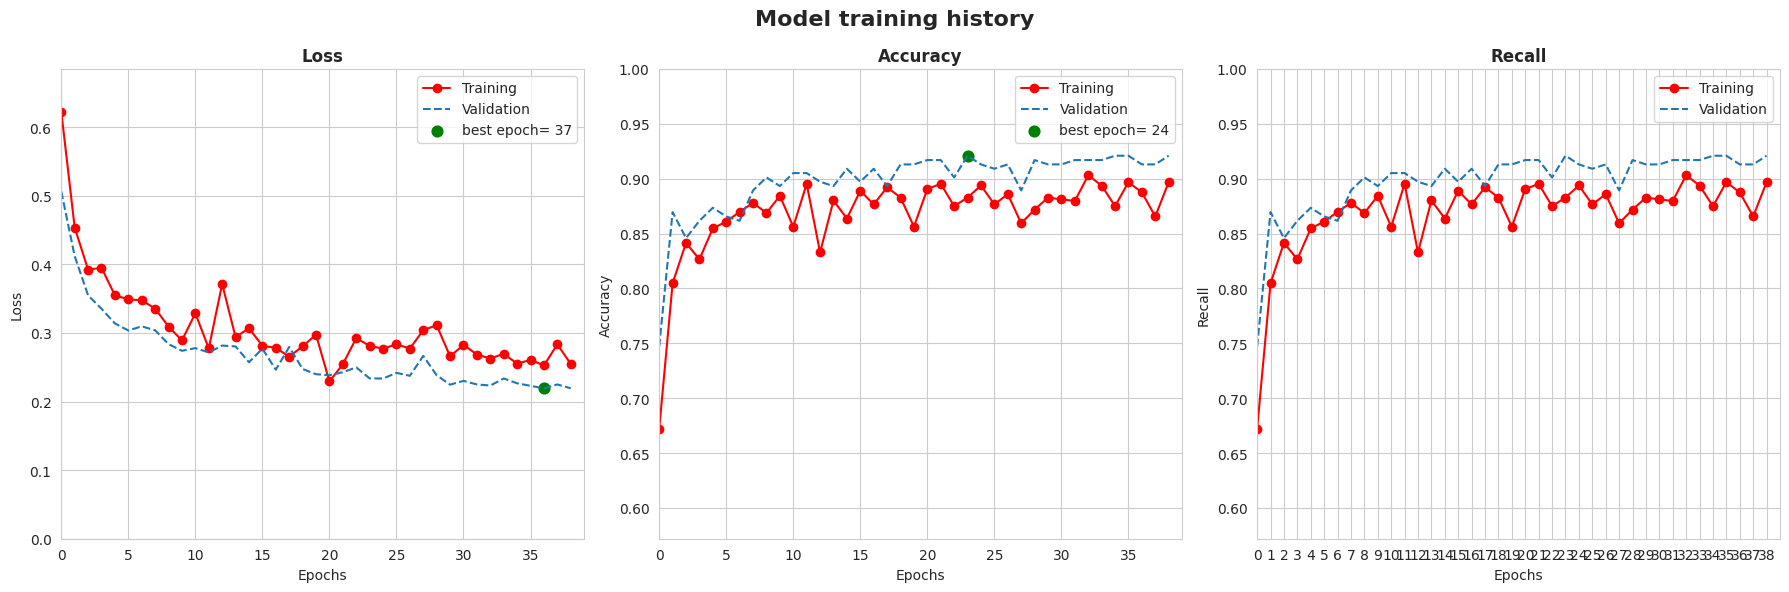

In [38]:
# Plot learning curves
metrics = pd.DataFrame(history.history)
plot_history(history)

### Evaluate modelo

In [39]:
train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train loss: ", train_score[0])
print("Train accuracy: ", train_score[1])
print('-' * 20)
print("Validation loss: ", valid_score[0])
print("Validation accuracy: ", valid_score[1])
print('-' * 20)
print("Test loss: ", test_score[0])
print("Test accuracy: ", test_score[1])

NameError: name 'model' is not defined

# **Get predictions**

In [40]:
preds = transfer_model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)
preds

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
[0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0
 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1
 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1
 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1
 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1
 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1]


array([[9.85163271e-01, 1.48367994e-02],
       [9.33703899e-01, 6.62960485e-02],
       [8.63493621e-01, 1.36506423e-01],
       [9.88687396e-01, 1.13125807e-02],
       [9.49966192e-01, 5.00337705e-02],
       [1.40565610e-03, 9.98594344e-01],
       [6.96812663e-03, 9.93031859e-01],
       [9.89698708e-01, 1.03012826e-02],
       [2.20623356e-03, 9.97793794e-01],
       [6.27493893e-04, 9.99372542e-01],
       [9.79117990e-01, 2.08819639e-02],
       [8.90169740e-01, 1.09830223e-01],
       [3.38451791e-05, 9.99966145e-01],
       [9.95871365e-01, 4.12866939e-03],
       [9.86905754e-01, 1.30942538e-02],
       [9.73983109e-01, 2.60168724e-02],
       [3.81765328e-02, 9.61823463e-01],
       [9.83762085e-01, 1.62379425e-02],
       [1.41978071e-05, 9.99985814e-01],
       [9.65447724e-01, 3.45522799e-02],
       [9.51017618e-01, 4.89824079e-02],
       [9.80695128e-01, 1.93049442e-02],
       [5.16355550e-03, 9.94836450e-01],
       [2.72599477e-02, 9.72740114e-01],
       [4.480938

In [41]:
g_dict = validation_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(validation_generator.classes, y_pred, target_names= classes))
cm

              precision    recall  f1-score   support

     healthy       0.49      0.47      0.48       121
       salmo       0.53      0.55      0.54       132

    accuracy                           0.51       253
   macro avg       0.51      0.51      0.51       253
weighted avg       0.51      0.51      0.51       253



array([[57, 64],
       [60, 72]])

## Fine-tuning VGG16 weights

In [42]:
# Unfreeze the base model
base_model.trainable = True

How many layers are in the base model:

In [43]:
f'Number of layers in the base model: {len(base_model.layers)}'

'Number of layers in the base model: 19'

In [44]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [45]:
base_learning_rate = 0.0001
transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #loss='categorical_crossentropy'
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10), #Very low lr
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [46]:
transfer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 11,832,002 (45.14 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

In [47]:
len(transfer_model.trainable_variables)

14

### Continue Training

And now we proceed to train the model:

In [48]:
fine_tune_epochs = 50
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_generator,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_generator,
                                       callbacks=[early_stopping, time_callback])

Epoch 39/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 375ms/step - accuracy: 0.8890 - loss: 0.2829 - recall_1: 0.8890 - val_accuracy: 0.9407 - val_loss: 0.1858 - val_recall_1: 0.9407
Epoch 40/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - accuracy: 0.9289 - loss: 0.2031 - recall_1: 0.9289 - val_accuracy: 0.9368 - val_loss: 0.1431 - val_recall_1: 0.9368
Epoch 41/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - accuracy: 0.9378 - loss: 0.1770 - recall_1: 0.9378 - val_accuracy: 0.9209 - val_loss: 0.1818 - val_recall_1: 0.9209
Epoch 42/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 327ms/step - accuracy: 0.9464 - loss: 0.1594 - recall_1: 0.9464 - val_accuracy: 0.9644 - val_loss: 0.1023 - val_recall_1: 0.9644
Epoch 43/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.9523 - loss: 0.1360 - recall_1: 0.9523 - val_accuracy: 0.9486 - val_loss: 0.1088 - val_recall_1: 0.9486
Epoch 44/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 327ms/step - accuracy: 0.9533 - loss: 0.1273 - recall_1: 0.9533 - val_accuracy:

In [49]:
metrics_tuned = pd.concat([metrics, pd.DataFrame(history_fine_tune.history)], ignore_index=True)

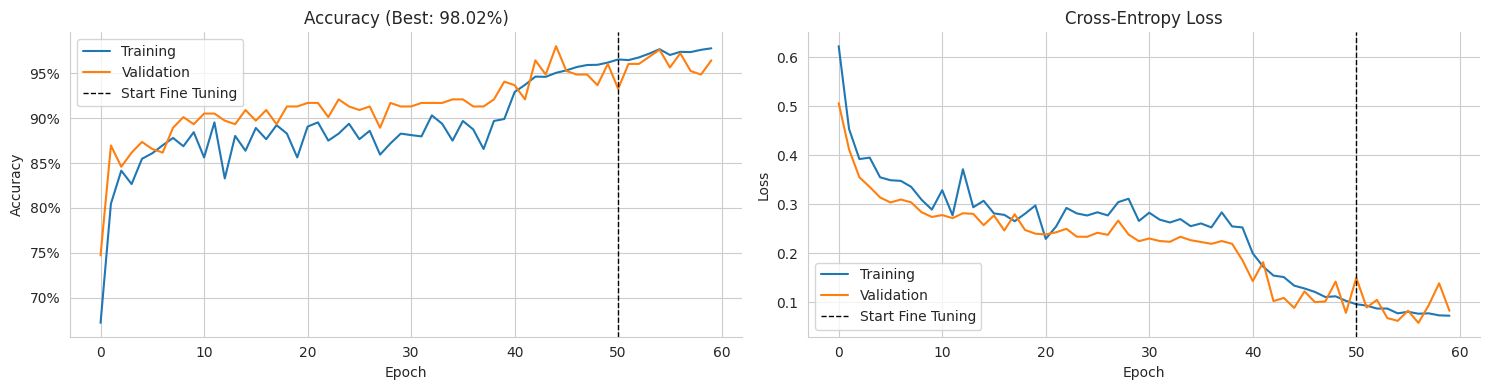

In [50]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(50, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
sns.despine()
fig.tight_layout()

## Evaluation and prediction

In [51]:
loss, accuracy, recall = transfer_model.evaluate(validation_generator)
print('Test accuracy :', accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9508 - loss: 0.1103 - recall_1: 0.9508
Test accuracy : 0.9644268751144409


In [52]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_generator.as_numpy_iterator().next()
predictions = transfer_model.predict_on_batch(image_batch).flatten()
class_names = ('Healthy','Salmonella')

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[predictions[i]])
  plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'as_numpy_iterator'